# Tensorflow & Keras  

Informatiquement on utiliseras tf.keras, mais encore une fois, n'hésitez pas à aller sur keras.io pour la documentation.  

Nous allons voir :

## Model

- Sequential  
- compile  
- fit  
- inputs  
- outputs  
- save / load

## Optimizer  

- SGD  
- Adam  

## Loss functions  & metrics

- Regression lf : 
    - mean squared error
    - mean absolute error  
- Categorical lf :  
    - BinaryCrossentropy
    - CategoricalCrossentropy
    - SparseCategoricalCrossentropy
- Accuracy  

## Layers

- Dense  
- Softmax  
- Dropout  
- BatchNormalization  
- Mathematical : lambda, minimum, add, ...
- Tensor manipulation : concatenate, reshape  

Next days :  

### Image processing layers  

- Conv2D  
- Maxpooling2d
- Flatten  

### RNN  

- LSTM  
- SimpleRNN  

### NLP  

- Embedding  

## Activation fonctions  

- relu et variantes  
- sigmoid  
- tanh  

## Callbacks  

- tensorboard  
- early stopping  
- custom (choose verbosity, monitor weights learning)  

In [0]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    print("tensorflow_version failed, i guess you are not in Colab")

In [12]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [13]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
import datetime as dt

print(f'Tensorflow version : {tf.__version__}')

Tensorflow version : 2.2.0


# Models

Les modèles sont les éléments de base. Ils sont essentiellement de deux types :  
- Sequential (chaque input est donné au suivant)  
- model (les inputs et les outputs sont spécifiés)

## Models => Sequential

https://keras.io/models/sequential/

Les modèles de type Sequential sont les plus simples :

In [22]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation = 'relu', name = 'hidden', input_shape = (2,)),
    tf.keras.layers.Dense(16, activation = 'relu', name = 'hidden2'),
    tf.keras.layers.Dense(1, name = 'output')
])

model1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 4)                 12        
_________________________________________________________________
hidden2 (Dense)              (None, 16)                80        
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 109
Trainable params: 109
Non-trainable params: 0
_________________________________________________________________


Nous avons créer un premier modèle avec deux layers, et qui prend une seule entrée. Il possède 13 paramètres.
8 pour le premier layer (4 neurones * (1 weight + 1 bias))  
5 pour le deuxième layer (1 neurone * (4 weight + 1 bias))

A noter la fonction .summary() qui est très utile pour avoir la structure de votre model.

Une autre fonction de débuggage utile est tf.keras.utils.plot_model(model, to_file='model.png')

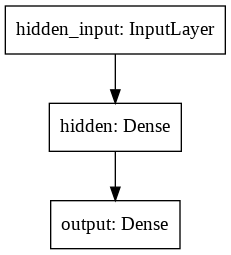

In [0]:
tf.keras.utils.plot_model(model1, to_file='model.png')

Les deux étapes suivantes du modèle sont la compilation, et l'entrainement :

### Compilation du modèle

In [0]:
model1.compile(optimizer='sgd', loss='mse', metrics=['mae'])

# ou 

model1.compile(
    optimizer=tf.keras.optimizer.SGD(learning_rate=0.01), 
    loss=tf.keras.losses.MeanSquaredError(), 
    metrics=['mae']
)

La compilation est indispensable et sert à indiquer au backend (ie tensorflow) de compiler le modèle. On peut lui spécifier un certains nombre de paramètres (https://keras.io/models/model/#compile). Les principaux sont :  
- loss : la fonction de coût. Elle est majoritairement imposée par le problème (mse est le choix le plus courant pour une régression)  
- optimizer : le moteur d'optimisation. sgd avec momentum et adam sont les plus courants
- metrics : d'autres indicateurs à afficher pendant l'optimisation. 'accuracy' est très utilisée pour les problèmes de classification

### Entrainement du modèle

Ici on aura besoin de donnée ! A noter que l'on utilise la fonction **fit**, par analogie avec scikit-learn.  

Les principaux arguments de la méthode fit sont :
- les données x et y  
- epochs, ie le nombre d'itérations à effectuer (NN ne s'arrête pas tout seul)  
- verbose => a mettre à 0 pour éviter tous les outputs 
- callback => nous y reviendrons, en résumé cela sert à monitorer le processus
- validation_split ou validation_data => pour définir des jeux de données de validation. Très utile avec la callback early_stopping

In [0]:
x = np.random.random(1000)
y = x + (x > 0.5)*0.2*(x - 0.5)

model1.fit(x, y, epochs = 5)

## Models => Model

La limite de sequential est que vous souhaitez parfois avoir une structure particulière. Par exemple nous verrons un jeu de donnée de la CNR (compagnie nationale du Rhone) où on a entrée 4 valeurs pour le vent, 2 pour la température et une pour la couverture nuageuse.

Si l'on souhaite construire un modèle qui aggrège les 4 valeurs du vent en 1 seule, puis construit la production en fonction de cette valeur aggrégée et de la température, on ne peut pas utiliser Sequential (qui enverra toutes les entrées au premier layer).

On va devoir définir les inputs et outputs :

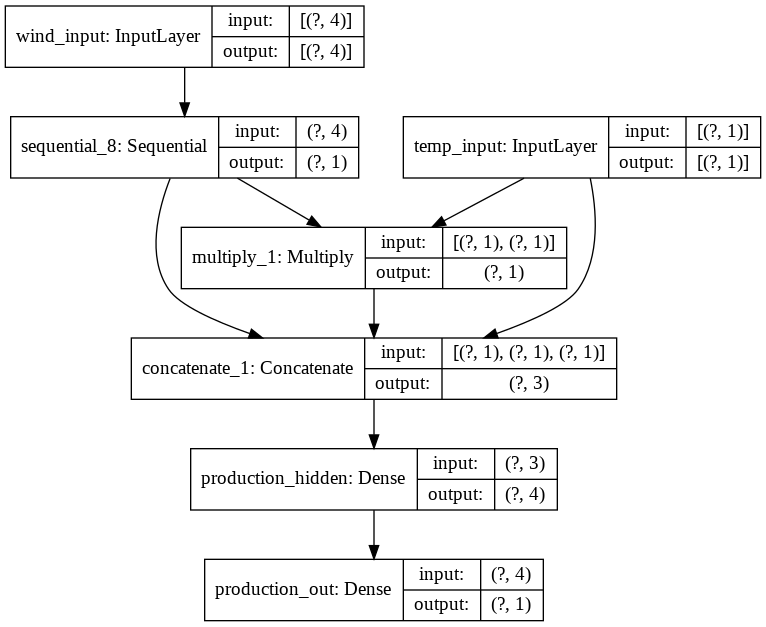

In [21]:
def windModel():
    # On définit les entrées et leurs dimensionnalité (le nombre d'éléments est omis)
    wind_input = tf.keras.Input(shape = (4,), name = 'wind_input')
    temperature_input = tf.keras.Input(shape = (1,), name = 'temp_input')
    
    # On définit deux layers propres au vent
    wind_seq = tf.keras.Sequential([
        tf.keras.layers.Dense(4, activation = 'relu', name = 'wind_hidden'),
        tf.keras.layers.Dense(1, name = 'wind_out')
    ])

    wind_out = wind_seq(wind_input)
    
    # On aggrège la sortie du modèle 
    wind_dot_temp = tf.keras.layers.multiply([temperature_input, wind_out])
    production_input = tf.keras.layers.concatenate([temperature_input, wind_out,wind_dot_temp])
    
    production_hidden = tf.keras.layers.Dense(4, activation = 'relu', name = 'production_hidden')(production_input)
    production_out = tf.keras.layers.Dense(1, name = 'production_out')(production_hidden)
    
    return tf.keras.Model(inputs = [wind_input, temperature_input], outputs = production_out)

wind_model = windModel()
tf.keras.utils.plot_model(wind_model, to_file='model.png', show_shapes=True)

### Model save / load

On peut sauvegarder et charger les modèles (y compris les poids qui auront été appris)

In [0]:
model1.save('model.h5')
model1 = tf.keras.models.load_model('model.h5')

### Acceder aux layers du modèle

On peut accéder aux layers du modèle via deux méthodes :
- model.layers => liste des layers  
- model.get_layer(name) => accès par nom  

Cela permet plusieurs choses :
- accéder au poids
- extraire les outputs intermédiaires  
- définir des layers / modèles comme non entrainable

A noter que les modèles peuvent inclure d'autres modèles !

### Tips : accéder aux sorties intermédiaires

In [23]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(6, activation = 'relu', name = 'hidden', input_shape = (1,)),
    tf.keras.layers.Dense(1, name = 'output')
])

x = np.random.normal(0, 1, 1000)
y = x ** 2

model1.compile(optimizer='sgd', loss='mse')
history = model1.fit(x, y, verbose = 0, epochs = 20)
print(history.history['loss'][-1])

#### TIPS ######
model1_with_inter = tf.keras.Model(
    inputs = model1.inputs,
    outputs = [model1.outputs, model1.get_layer('hidden').output]
)

# Output model 1 
X = np.concatenate([x[:0], [x.min(), x.max()]])
print('===== model original =====')
print(model1.predict(X))
# Output model 1 avec intermédiaire
pred, pred_inter = model1_with_inter.predict(X)
print('===== model aug 1 =====')
print(pred)
print('===== hidden 1 =====')
print(pred_inter)

0.1334051489830017
===== model original =====
[[6.6614013]
 [6.8379526]]
===== model aug 1 =====
[array([[6.6614013],
       [6.8379526]], dtype=float32)]
===== hidden 1 =====
[[0.        0.        3.2215872 2.0087867 1.365518  0.       ]
 [2.9870296 0.        0.        0.        0.        2.3579957]]


### Model utils

Pour dessiner le modèle

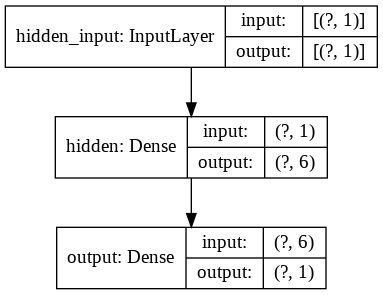

In [25]:
tf.keras.utils.plot_model(model1, to_file='model.png', show_shapes=True)

Pour la version texte

In [26]:
model1.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 6)                 12        
_________________________________________________________________
output (Dense)               (None, 1)                 7         
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


## Optimizer  

Il existe beaucoup d'optimizer et vous pourrez trouver beaucoup de vidéos dessus.  
Les deux les plus fréquemment utilisés sont le plus simple et le plus complexe :

- SGD  
- Adam  

Tensorflow vous autorise beaucoup d'autres optimizers, le problème est de savoir comment le choisir. Pour l'instant une bonne stratégie de les tester, en faisant varier le learning rate.  

En bref (à prendre avec des pincettes):
- SGD semble plus stables
- Adam évite le problème des "saddle points" et est plus adaptés aux problèmes avec énormément de paramêtres.

Vous pouvez les utilisez en utilisant leur nom en string :

In [0]:
model1.compile(optimizer='sgd', loss='mse')
model1.compile(optimizer='adam', loss='mse')

Mais cela ne vous laisse pas définir les paramêtres. Il y a deux importants :  
- learning_rate  
- momentum pour le SGD (SGD avec momentum 0.9 est un choix très populaire)

In [0]:
model1.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum = 0.9), loss='mse')
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

Attention à ce que le choix de l'optimiser intervient dans 2 cas :  
- soit tout à la fin de votre modèle  
- soit sur des problèmes sur lesquels vous avez déjà beaucoup d'expérience  

En phases plus exploratoires, il y a beaucoup plus importants à faire sur le feature engineering ou sur la structure de votre modèle.

## Loss functions  & metrics

Il est possible de définir votre propre loss functions, mais cela suppose déjà une très grande connaissance de votre modèle. Concrètement cela dépend principalement de votre problème :

### Régression

Par défaut 'mse' (pour mean squared error) pour ces bonnes propriétés mathématiques.  
mae (mean absolute error) peut être un autre choix, suivant la problématique réelle (elle favorisera plus l'erreur moyenne quand mse accorde beaucoup de poids aux erreurs extrêmes)  

### Catégorisation

Ici on cherche à définir si un objet appartient à une ou plusieurs classes ou labels (par convention, les classes sont exclusives, pas les labels).   

- BinaryCrossentropy : si il n'y a que deux possibilités ou que les possibilités sont non exclusives  

Si vous avez des classes mutuellement exclusives, il y a deux possibilités suivant le format de vos labels de tests :

- CategoricalCrossentropy : en format 1-hot encoding (ie [0, 0, 1], [1, 0, 0])
- SparseCategoricalCrossentropy : en format entier (ie 3, 7, 9, 2, 0)

Important ! Pensez à rajouter from_logits = True si votre modèle produit des scores (non limités) plutôt que des probabilités (comprises entre 0 et 1)

In [0]:
model1.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

### Metrics

Vous pouvez ajouter des metrics à côté de la fonction de coût. Elles ne sont pas utilisées pour la rétro-propagation du gradient mais peuvent l'être pour arrêter l'apprentissage.

In [0]:
model1.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

## Layers

Ce sont les briques élémentaires de votre réseaux. Vous avez déjà croisé un certain nombre de Dense layers.  

### Dense

https://keras.io/layers/core/#dense

C'est le layer le plus classique, dans les couches de régression et de classification (NB : nous verrons demain que les réseaux de neurones de traitement d'image sont composés de deux couches, une couche de "feature extraction" et une couche de catégorisation.)

Le principe du layer Dense est que chaque neurone est connecté à toutes les sorties de la couche précédente. Ainsi un Dense avec 10 neurones suivant un Dense avec 16 neurones aura 16 * 10 => 160 poids.

Il possède 1 paramêtre obligatoire, le nombre de neurones.  
Il possède un paramêtre fortement recommandé, la fonction d'activation (il s'agit de linear par défaut, alors qu'il ne sert absolument à rien d'empiler les layers linear).  
Voir la documentation pour les autres paramêtres, un des plus utiles est use_bias (True par défaut, permet de supprimer le biais).  
Tous les paramêtres de type kernel_initializer sont à utiliser avec précaution !  
A noter que pour la fonction d'action relu, il semblerait que 'he_uniform' soit le meilleur paramêtrage par défaut.

Chaque neurone produit une sortie égale à $f(\sum_i {w_i * X_i} + b)$ où f est la fonction d'activation.

In [0]:
dense_layer = tf.keras.layers.Dense(
    10, 
    activation='relu', # la plupart du temps cela s'arrête là
    use_bias = False, 
    input_shape = (4,),
    kernel_initializer = 'he_uniform'
)

## Dropout

C'est un layer un peu particulier, qui sert avant tout à éviter le sur-apprentissage. On lui donne un paramêtre, et il "drop" la fraction correspondante des entrées à chaque itération pendant la phase d'entrainement (il ne fait rien pendant la phase d'apprentissage)

Sa fonction est d'éviter le sur-apprentissage

Note technique, il multiplie les autres valeurs par 1 / (1 - drop_param) 

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.25), # 25% des sorties du layers sont mises à 0 à chaque itération 
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1)
])

## Layer Softmax  

Calcule la fonction Softmax, qui correspond à :  
$Z_i = \frac{exp(X_i)}{\sum_i{exp(X_i)}}$

Ainsi chaque sortie est positive et leur somme vaut 1. Elle sert principalement de layer final pour les problèmes de catégorisation multi-classes.

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Softmax() # Il y a 8 sorties
])

## BatchNormalization

Un layer qui a pour objet de normaliser les sorties du layer précédent en calculant un moyenne de 0 et un écart type de 1, comme on le fait typiquement sur les données d'entrées.

Sert à accélérer et stabiliser le modèle.

In [0]:
model = tf.keras.Sequential([
    layers.Dense(16, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dense(16, activation = 'relu'),
    layers.Dense(1)
])

## Tensor manipulation

### Flatten

Un des layer les plus couramment utilisés est le layer Flatten, qui ramène tous les éléments sur une seule dimension.  
Typiquement, il prendra en entrée une image (28, 28) et renverra un tensor (576).  
C'est important pour être en input des layers Dense, qui joue uniquement sur la dernière dimension.  

### Concatenate

Pour celui-ci, revoir le modèle de vent ci-dessous.  
Un des principaux usages est de donner en entrée d'un layer 2 tenseurs. Les layers ne prenant qu'un seul tenseur en entrée, il faut les concaténer (par exemple un tenseur (32, 3) et un tenseur (32, 2) sont transformés en tenseur (32, 5). 

Il est équivalent aux fonctions équivalentes sur numpy et pandas par exemple, mais il assure également la rétro-propagation du gradient.

In [0]:
def windModel():
    # On définit les entrées et leurs dimensionnalité (le nombre d'éléments est omis)
    wind_input = tf.keras.Input(shape = (4,), name = 'wind_input')
    temperature_input = tf.keras.Input(shape = (1,), name = 'temp_input')
    
    # On définit deux layers propres au vent
    wind_hidden = tf.keras.layers.Dense(4, activation = 'relu', name = 'wind_hidden')(wind_input)
    wind_out = tf.keras.layers.Dense(1, name = 'wind_out')(wind_hidden)
    
    # On aggrège la sortie du modèle 
    production_input = tf.keras.layers.Concatenate()([temperature_input, wind_out])
    
    production_hidden = tf.keras.layers.Dense(4, activation = 'relu', name = 'production_hidden')(production_input)
    production_out = tf.keras.layers.Dense(1, name = 'production_out')(production_hidden)
    
    return tf.keras.Model(inputs = [wind_input, temperature_input], outputs = production_out)

### Reshape

Equivalent à la fonction numpy (mais là encore en s'intégrant dans tensorflow)

## Mathematical : lambda, minimum, add, square, ...

Une des forces des réseaux de neurones est de pouvoir combiner des opérations mathématiques classiques avec les layers d'apprentissage.

Nous travaillerons plus sur ce type d'opérateurs lors du TP sur la CNR.  
On peut multiplier des tenseurs, les additionner, en mettre au carré, etc ...

## Activation fonctions  

- relu et variantes

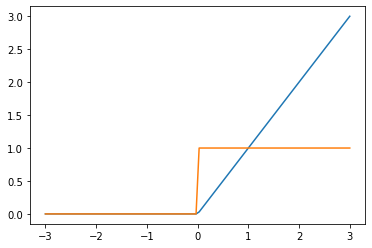

In [14]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-3, 3, 100)

epsilonn = 1e-4
def derive(f, x):
    return (f(x + epsilonn) - f(x - epsilonn))/(2 * epsilonn)

plt.plot(x, tf.keras.activations.relu(x))
plt.plot(x, derive(tf.keras.activations.relu, x))

- sigmoid

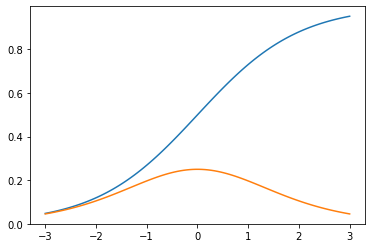

In [0]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-3, 3, 100)

plt.plot(x, tf.keras.activations.sigmoid(x))
plt.plot(x, derive(tf.keras.activations.sigmoid, x))

- tanh

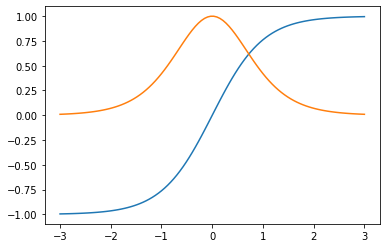

In [0]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-3, 3, 100)

plt.plot(x, tf.keras.activations.tanh(x))
plt.plot(x, derive(tf.keras.activations.tanh, x))

## Callbacks  
 
- early stopping  

In [28]:
x = np.random.normal(0, 1, 1000)
y = x ** 2 + 5 * np.random.normal(0, 1, 1000)

model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation = 'tanh'),
    tf.keras.layers.Dense(32, activation = 'tanh'),
    tf.keras.layers.Dense(32, activation = 'tanh'),
    tf.keras.layers.Dense(1, name = 'output')
])

class CustomCB(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 10 == 0:
            print(logs)

model1.compile(optimizer = 'sgd', loss = 'mse')
model1.fit(x, y, validation_split = 0.2, epochs = 200, verbose = 0, callbacks = [CustomCB()])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

{'loss': 26.10080337524414, 'val_loss': 27.178979873657227}
{'loss': 25.669958114624023, 'val_loss': 26.50466537475586}
{'loss': 25.165815353393555, 'val_loss': 25.374113082885742}
{'loss': 25.231714248657227, 'val_loss': 25.1866397857666}
{'loss': 24.813400268554688, 'val_loss': 25.090068817138672}
{'loss': 24.591623306274414, 'val_loss': 24.801246643066406}
{'loss': 24.607158660888672, 'val_loss': 24.764019012451172}
{'loss': 24.668907165527344, 'val_loss': 24.855125427246094}
{'loss': 24.618806838989

In [30]:
x = np.random.normal(0, 1, 1000)
y = x ** 2 + 5 * np.random.normal(0, 1, 1000)

model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation = 'tanh'),
    tf.keras.layers.Dense(32, activation = 'tanh'),
    tf.keras.layers.Dense(32, activation = 'tanh'),
    tf.keras.layers.Dense(1, name = 'output')
])

model1.compile(optimizer = 'sgd', loss = 'mse')
history = model1.fit(
    x, 
    y, 
    validation_split = 0.2, 
    epochs = 200, 
    verbose = 1, 
    callbacks = [CustomCB(), tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)]
)

history.history['val_loss'][-11:]

Epoch 1/200

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 0s 5ms/step - loss: 28.2997 - val_loss: 23.6169
Epoch 2/200
25/25 [==============================] - 0s 3ms/step - loss: 27.9473 - val_loss: 23.3385
Epoch 3/200
25/25 [==============================] - 0s 3ms/step - loss: 27.9774 - val_loss: 22.9344
Epoch 4/200
25/25 [==============================] - 0s 3ms/step - loss: 27.9847 - val_loss: 23.2748
Epoch 5/200
25/25 [==============================] - 0s 3ms/step - loss: 27.8349 - val_loss: 23.0300
Epo

[20.154539108276367,
 22.354066848754883,
 20.880027770996094,
 21.060497283935547,
 20.29137420654297,
 20.629131317138672,
 20.917909622192383,
 20.336685180664062,
 20.40451431274414,
 20.834993362426758,
 20.68653106689453]

- Tensorboard

In [0]:
import datetime as dt

x = np.random.normal(0, 1, 1000)
y = x ** 2 + 5 * np.random.normal(0, 1, 1000)

model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation = 'tanh'),
    tf.keras.layers.Dense(32, activation = 'tanh'),
    tf.keras.layers.Dense(32, activation = 'tanh'),
    tf.keras.layers.Dense(1, name = 'output')
])

model1.compile(optimizer = 'sgd', loss = 'mse')

log_dir="logs/fit/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")

history = model1.fit(
    x, 
    y, 
    validation_split = 0.2, 
    epochs = 200, 
    verbose = 0, 
    callbacks = [CustomCB(), tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)]
)

In [0]:
%tensorboard --logdir logs/fit